This text classification tutorial trains a recurrent neural network on the IMDB large movie review dataset for sentiment analysis.

In [60]:
# Setup
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Now will import matplotlib and create a helper function to plot graphs:

In [61]:
import matplotlib.pyplot as plt

def plot_graphs(history,metric):
        plt.plot(history.history[metric])
        plt.plot(history.history['val_'+metric],'')
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend([metric,'val_'+metric])

Setup input pipeline

The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.

In [62]:
dataset, info = tfds.load('imdb_reviews',with_info=True,as_supervised=True)
train_dataset,test_dataset = dataset['train'],dataset['test']
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text,label pairs)

In [63]:
for example, label in train_dataset.take(1):
    print('text:',example.numpy())
    print('label:',label.numpy())

text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label: 0


Next shuffle the data for training and create batches of these (text, label) pairs.

In [64]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [65]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [66]:
for example, label in train_dataset.take(1):
    print('texts:',example.numpy()[:3])
    print()
    print('labels:',label.numpy()[:3])

texts: [b'As a Native film professor, I can honestly say that this is perhaps one of the worst films with Native content that I have ever viewed. I would rather get a root canal than view this film again. The use of stereotyping, uncreative attempts at utilizing portions of traditional coyote stories and poor camera work were only made worse by the glib uncreative story-line and bad script. The writer and director have displayed the worst parts of a colonized approach to portraying Native people and communities. If this person is Native, they need to go home and apologize to everyone they know for being an apple and for the internalized racism and poor sense of humor that they have developed. If this person is non-native, they need to seriously re-examine their white privilege and ask themselves if they are displaying unexamined, unintentional racism, or if they are intentionally being ignorant. My only hope is that the Native actors in this film had a good time and at least got paid f

Create the text encoder

The raw text loaded by tfds needs to be processed before it can be used in a model. The simplest way to process text for training is using the TextVectorization layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's .adapt method:

In [67]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label:text))

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency.

In [68]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed output_sequence_length)

In [69]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[15,  4,  1, ...,  0,  0,  0],
       [ 1, 70, 11, ...,  0,  0,  0],
       [11, 20,  7, ...,  0,  0,  0]], dtype=int64)

With the default settings, the process is not completely reversible. There are three main reasons for that:

The default value for preprocessing.TextVectorization's standardize argument is "lower_and_strip_punctuation".
The limited vocabulary size and lack of character-based fallback results in some unknown tokens. 

In [70]:
for n in range (3):
    print('original:',example[n].numpy())
    print('Round-trip:',''.join(vocab[encoded_example[n]]))
    print()

original: b'As a Native film professor, I can honestly say that this is perhaps one of the worst films with Native content that I have ever viewed. I would rather get a root canal than view this film again. The use of stereotyping, uncreative attempts at utilizing portions of traditional coyote stories and poor camera work were only made worse by the glib uncreative story-line and bad script. The writer and director have displayed the worst parts of a colonized approach to portraying Native people and communities. If this person is Native, they need to go home and apologize to everyone they know for being an apple and for the internalized racism and poor sense of humor that they have developed. If this person is non-native, they need to seriously re-examine their white privilege and ask themselves if they are displaying unexamined, unintentional racism, or if they are intentionally being ignorant. My only hope is that the Native actors in this film had a good time and at least got paid

Above is a diagram of the model.

This model can be build as a tf.keras.Sequential.

The first layer is the encoder, which converts the text to a sequence of token indices.

After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.

The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

After the RNN has converted the sequence to a single vector the two layers.Dense do some final processing, and convert from this vector representation to a single logit as the classification output.

In [71]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check Keras RNN guide for more details.

The embedding layer uses masking to handle the varying sequence-lengths. All the layers after the Embedding support masking.

In [72]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask.

In [73]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.00572369]


Now, evaluate it again in a batch with a longer sentence. The result should be identical.

In [74]:
# predict on a sample text with padding

padding = 'the'*2000
predictions = model.predict(np.array([sample_text,padding]))
print(predictions[0])

1/1 [==============================] - 0s 71ms/step
[0.00572368]


Compile the Keras model to configure the training process.

In [75]:
model.compile(loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])

Train the model.

In [76]:
history = model.fit(train_dataset,epochs=2,validation_data=test_dataset,validation_steps=30)

Epoch 1/2
391/391 [==============================] - 1890s 5s/step - loss: 0.6374 - accuracy: 0.5672 - val_loss: 0.4801 - val_accuracy: 0.7078
Epoch 2/2
391/391 [==============================] - 1516s 4s/step - loss: 0.4443 - accuracy: 0.7903 - val_loss: 0.4079 - val_accuracy: 0.7984


In [77]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 2644s 7s/step - loss: 0.3940 - accuracy: 0.8011
Test Loss: 0.39403629302978516
Test Accuracy: 0.8011199831962585


(0.0, 0.6488404408097267)

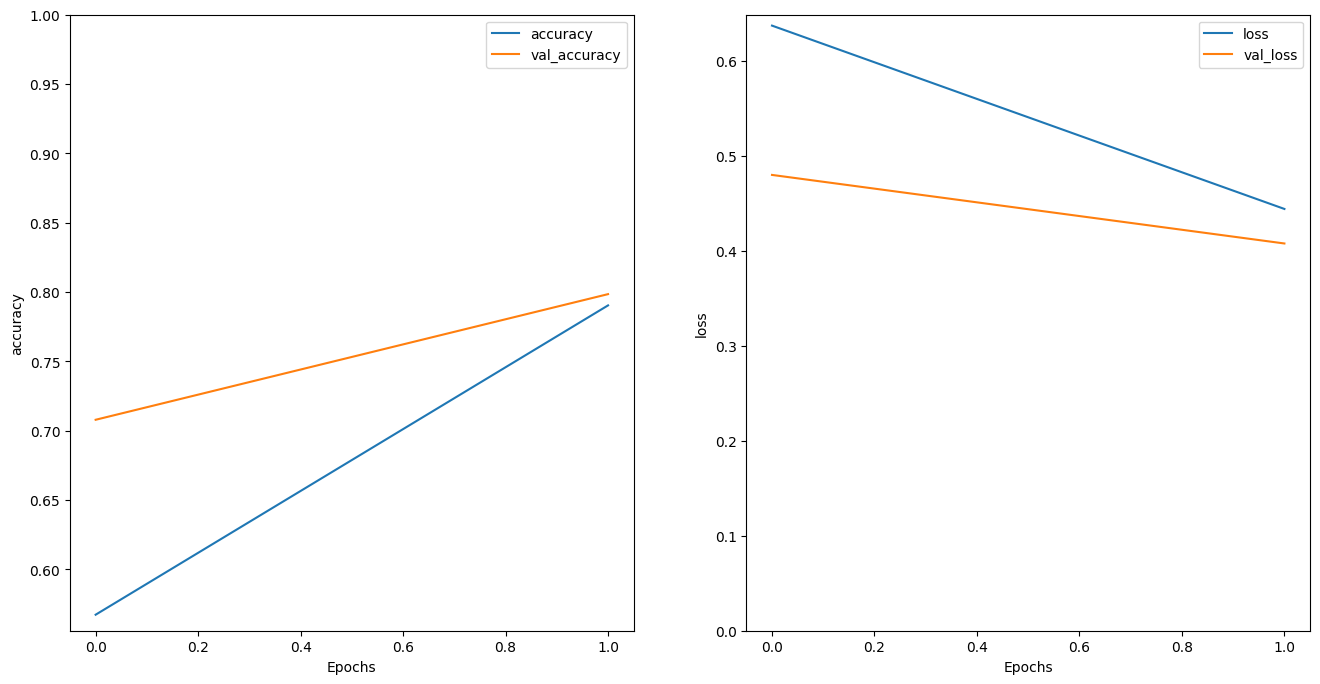

In [78]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [79]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 8s 8s/step


Stack two or more LSTM layers
Keras recurrent layers have two available modes that are controlled by the return_sequences constructor argument:

If False it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

If True the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape (batch_size, timesteps, output_features)).

The interesting thing about using an RNN with return_sequences=True is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this.

In [80]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/2
391/391 [==============================] - 3374s 9s/step - loss: 0.6321 - accuracy: 0.5828 - val_loss: 0.4584 - val_accuracy: 0.7844
Epoch 2/2
391/391 [==============================] - 2724s 7s/step - loss: 0.4023 - accuracy: 0.8211 - val_loss: 0.3569 - val_accuracy: 0.8406


In [81]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 811s 2s/step - loss: 0.3485 - accuracy: 0.8497
Test Loss: 0.34850063920021057
Test Accuracy: 0.8497200012207031


In [82]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 10s 10s/step
[[-0.61370945]]


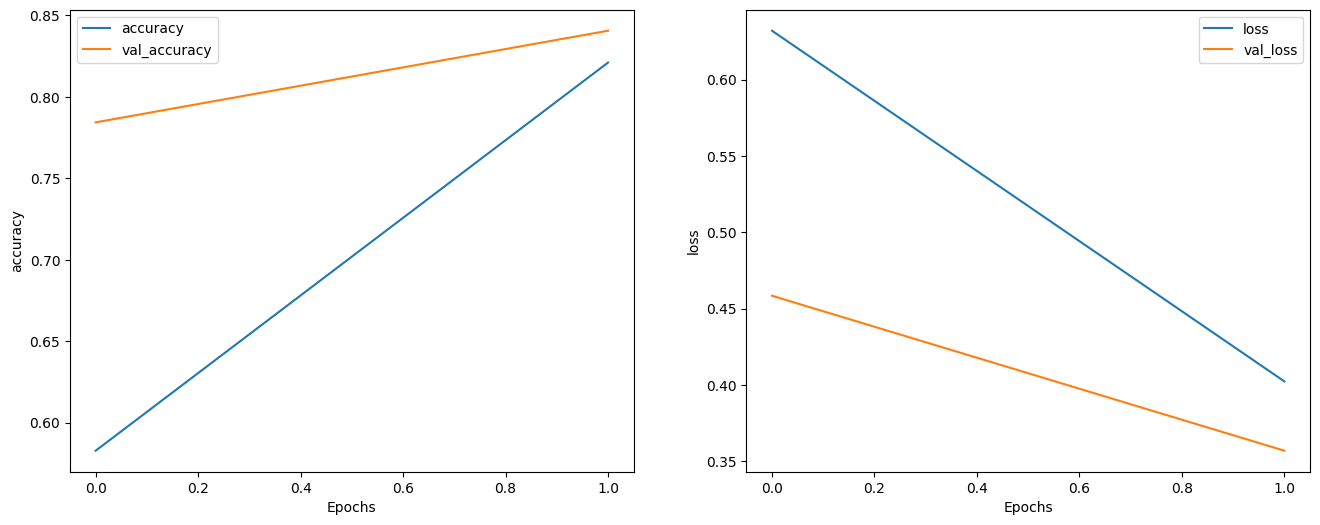

In [83]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')